In [ ]:
#Colin Hwang and Fakharyar Khan
#ECE-475: Frequentist Machine Learning
#Project 2: Logistic Regression
#Professor Keene

#importing all the necessary datatypes

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import seaborn as sns
import operator
from matplotlib import pyplot as plt



In [ ]:
#extracts the dataset from the csvfile
#splits dataset into training, validation, and testing sets
#takes in the filename of the csvfile, the name of the label for the dataset, and a list of the names of all of the cateogrical features

def prepare_data(filename, label, categ):

  #our processing function didn't generalize completely to all of the datasets
  #so we needed to process each dataset a little bit differently

  #if on the SA heart disease dataset
  if(label == "chd"):

    #make the first column the index
    df = pd.read_csv(filename, index_col = [0])

    #and because it contains a non-numerical feature, family history, we can use
    #one-hot encoding to make it numerical

    df.famhist = df.famhist.replace({"Present": 1, "Absent": 0})
  
  #if on the beans dataset
  elif label == "Class":

    #the csv file uses an encoding different from the one read_csv assumes by default
    df = pd.read_csv(filename, encoding= 'unicode_escape')

    #uses one hot encoding to encode the different classes of the label as binary strings
    df.Class = df.Class.replace({"SEKER": "000", "BARBUNYA": "001", "BOMBAY":"010",
                                 "CALI": "011", "DERMASON": "100", "HOROZ":"101", "SIRA":"110"})
    
  
  elif label == "stabf":
    df = pd.read_csv(filename)
    df.stabf = df.stabf.replace({"unstable": 1, "stable": 0})
  
  #else we're reading from the heart failure dataset for which we can just use the default parameters of the 
  #read_csv function

  else:
    df = pd.read_csv(filename)





  
  #split the dataset into training (80%), testing (10%), and validation (10%) sets
  train, test = train_test_split(df, test_size = 0.2)

  validation, test = train_test_split(test, test_size = 0.5)

  
  #extract the labels from each set which will create two dataframes for each set
  #Our notation for these dataframes is: 
  # {type_data}_{type_set} where type_data indicates whether the dataframe contains features (x)
  #or labels (y) and type_set indicates what set the dataframe belongs to (train, test, validation)

  ytrain = train[label]
  xtrain = train.drop(label, axis = 1)
  
  ytest = test[label]
  xtest = test.drop(label, axis = 1)

  vtest = validation[label]
  vtrain = validation.drop(label, axis = 1)

  #before normalizing the feature dataframes, we take out the categorical features

  xtrain_categ = train[categ]
  xtest_categ = test[categ]
  vtrain_categ = validation[categ]

  xtrain = xtrain.drop(categ, axis = 1)
  xtest = xtest.drop(categ, axis = 1)
  vtrain = vtrain.drop(categ, axis = 1)


  #normalizing the numerical features
  xtrain = (xtrain - xtrain.mean())/xtrain.std()
  xtest = (xtest - xtest.mean())/xtest.std()
  vtrain = (vtrain - vtrain.mean())/vtrain.std()

  
  #and after we're done normalizing them, we put the categorical features back in
  xtrain = pd.concat([xtrain, xtrain_categ], axis = 1)
  xtest = pd.concat([xtest, xtest_categ], axis =1)
  vtrain = pd.concat([vtrain, vtrain_categ], axis =1)

  

  return xtrain, ytrain, xtest, ytest, vtrain, vtest




In [ ]:
#This code block is basically where the classification algorithms (except for stretch goal #2) are implemented

#this is our update function
#it updates all of the weights using stochastic gradient descent 

#it takes in: the old weight vector, beta_old, the features of a single datapoint, xi,
#and its label, yi, the lambda paramter for regularization, lamb, the step size for
#gradient descent, alpha, and L2, a boolean that tells us whether to do L2 or L1 regularization

#it returns the updated weight vector
def step(beta_old, xi, yi, lamb, alpha, L2):

  #first update the weight vector by taking a step in the direction of the gradient
  #of the log_likelihood function

  beta_new = beta_old + alpha*(yi - hyp_func(beta_old, xi))*xi

  #then if we're doing L2 regularization
  if L2:
    #we add in the gradient of the L2 penalty
    return  beta_new - [beta*lamb for beta in beta_old]
  
  #else we're doing L1 regularization
  #since the L1 penalty isn't differentiable at 0 we can't just take the gradient
  #of the penalty to get the update vector
  #instead we used one of the weight update procedures described in this paper: https://aclanthology.org/P09-1054.pdf
  #called SGD-L1 (Clipping)
  
  #in this method after adding in the update component from the likelihood function
  #you add the derivative (+- lambda) of the L1 penalty but if there's a sign change, the weight gets clipped to 0
  
  return [max(0, beta - alpha*lamb) if beta > 0 else min(0, beta + alpha*lamb) for beta in beta_new]


#hyp_func evaluates the sigma function at the dot product of beta and x, the list of feature values
#for a datapoint
#its output is the conditional probability that the datapoint is a 1 given its feature values

def hyp_func(beta, x):

  #take the transpose of beta
  beta_tran = np.transpose(beta)

  #return the sigmoid function evaluated at the matrix product of the transpose of beta
  #and x (or the dot product)

  return (1 + math.exp(-1*np.matmul(beta_tran, x)))**-1

#here we fit the model
#by going through every data point in the training set
#and updating the weight vectors using the step function

#takes in x, the training set, y the list of labels,
#alpha, the step size parameter, and L2 a boolean that tells use
#if we're performing L2 or L1 regularization

def fit_model(x, y, lamb, alpha, L2):

  #make space for a vector that has as many entries as there are features
  #it's advised to start SGD with all of the weights as 0

  beta = [0]*np.shape(x)[1]
  
  #go through every data point
  #and update the weights using the step function

  for index in range(np.shape(x)[0]):
    beta = step(beta, x[index], y[index], lamb, alpha, L2)

  return beta

# calculates the log likelihood of our dataset occuring in the probability distribution
# predicted by our model if we maximize this value, assuming our training set isn't biased,
# we would have found an estimate for the probability distribution of the sample space

#takes in the the weight vector calculated by the model, beta, the feature values, x,
#and the labels, y

#this function doesn't actually get used in the code. We were going to use it
#to access the performance of the model on the validation set for when we needed to
#tune the regularization parameters and perform cross validation
#but we found that using the percent of correct classification on the training set 
#yielded better results for all of the datasets we used

def log_likelihood(beta, x, y):

  prob = 0

  #go through every data point
  for index in range(np.shape(x)[0]):

    #and since each datapoint is independent, we can multiply the probability of them occuring
    #together but since we took the log of the likelihood, we add them instead

    prob += y[index]*math.log(hyp_func(beta, x[index]))
    
    prob += (1 - y[index])*math.log(1- hyp_func(beta, x[index]))

  
  return math.exp(prob)

#the predict function sees how well our model does at classifying
#the testing/validation set
#calculates the percent of the set that the model correctly predicted

#takes in weight vector calculated by model, beta, feature values, and labels

def predict(beta, x, y):

  numCorrect  = 0

  #go through each datapoint
  for index in range(np.shape(x)[0]):

    prediction = 0
    #since hyp_func calculates probability of y being 1 given x,
    #if it's > 0.5, we can say that it's more likely than not that the label is 1
    #if it's < 0.5, then we say that the model predicted a label of 0

    proby1 = hyp_func(beta, x[index])
    if proby1 > 0.5:
      prediction = 1
    
    #if we got it right, add one to numCorrect
    if prediction == y[index]:
      numCorrect += 1
  
  #find percent correct
  return 100* numCorrect/len(y)


    

In [ ]:
#this driver function pulls all of the functions in the previous code block
#to generate and test the performance of the model

#takes in a training set with features in trainx, and labels in trainy
#a testing/validation set with features in testx and labels in testy
#lamb, the regularization parameter, L2, a boolean that tells it to do L2 or L1 regularization
#and output, a boolean that tells the function to output the percent correct if false
#or return the weights and percent correct if true

def driver(trainx, trainy, testx, testy, lamb, alpha, L2, output):

  #convert trainx and trainy into numpy arrays
  xtrain_mat = trainx.to_numpy()

  size = np.size(xtrain_mat, 0)

  #and append a column of ones to xtrain_mat so that we have a weight
  #that represents the y-intercept

  xtrain_mat = np.c_[np.ones(size), xtrain_mat]

  ytrain_mat = trainy.to_numpy()
  
  #train the model on the training set and get the weight vector
  beta = fit_model(xtrain_mat, ytrain_mat, lamb, alpha, L2)

  #now we need to see how it does on the testing set
  #convert xtest and ytest into numpy arrays
  #and append a column of 1s to xtest_mat

  xtest_mat = testx.to_numpy()

  size = np.size(xtest_mat, 0)

  xtest_mat = np.c_[np.ones(size), xtest_mat]
  ytest_mat = testy.to_numpy()

  #call on predict function to get the percent of labels in testing set
  #that model predicted correctly

  score = predict(beta, xtest_mat, ytest_mat)
  likelihood = log_likelihood(beta, xtest_mat, ytest_mat)

  #if output is true, return the weights and the score
  if(output):
    return beta, score

  #else just return the score
  return score

#this function impements the forward stepwise feature selection algorithm
#it selects the most important group of features in the following way:

#build all of the one-feature models. Choose the best k of them
#build all 2-feature models from the k best one-feature models
#build all 3-feature models from the k best two feature models and so on

#takes in the regularization parameter, lamb, the step parameter, alpha,
#the number of models to choose in each iteration, num_mod, and the number of 
#iterations of the algorithm the function should perform, num_feat

#outputs the num_feat most important features according to the function

def forward_selection(alpha, num_mod, num_feat):

  #create two dictionaries
  #they will both map a score to the model (a list of features used in the model, betas can be reproduced)
  #it's possible that in an iteration, two models can end up having the same score
  #and one would overwrite the other in the dictionary but that's really unlikely

  feat_dict = {}
  feat_dict_new = {}

  #assign the null model a score of 0 (or ig the other way around)
  #since u can only get a value of 0 from the null model, for every datapoint
  #it always gives a probability of 0.5 for the label being a 1 which isn't a decision
  #in any direction so it couldn't technically predict any of the labels correctly

  feat_dict[0] = []

  #get the set of the names of all of the features
  all_features = set(xtrain.columns)


  #in each iteration
  for iter in range(num_feat):

    #feat_dict_new will hold the performance of the models from the current iteration
    #feat_dict holds the values from the previous iteraton



    #empty out feat_dict_new
    feat_dict_new = {}

    #iterate through the models from the previous iteration (the keys are their scores)
    for model in feat_dict.keys():

      #iterate through every feature that wasn't used by the current model
      for feature in all_features - set(feat_dict[model]):

        #append that feature to the list of features used by the model
        model_chall = feat_dict[model] + [feature]

        #use those features to train the model and access its performance on the 
        #validation set
        
        score = driver(xtrain[model_chall], ytrain, xval[model_chall], 
                            
                            yval, 0 , alpha, False, False)
        
        #add the model and its score to feat_dict_new since it's a model from this
        #iteration
        feat_dict_new[score] = model_chall
    
    #get a list of the scores of the num_mod best models
    best_mod = (sorted(feat_dict_new.keys(), reverse = True))[0: num_mod - 1]

    #empty out feat_dict
    feat_dict = {}

    #and fill it up with the num_mod best models of this iteration
    #since in the next iteration they will be the models of the previous iteration
    for mod in best_mod:
      feat_dict[mod] = feat_dict_new[mod]
  
  #return the best performing model from the last iteration
  return feat_dict[(sorted(feat_dict.keys(), reverse = True))[0]]





#sweeps through lambda and finds the best regularization parameter

#takes in L2 which determines whether to use L1 or L2 regularization
#and plot which tells it whether or not to return coeff, an output necessary 
#for plotting the weights of the coefficients as a function of lambda

def opt_lamb(L2, plot):


  opt_lamb = 0

  #coeff is a list of lists of weights
  #we'll append the weight vectors of each model to here

  coeff = []

  #create a range of values for lambda to take on
  lambdas = np.arange(0, 2, 0.01)

  
  max_score = 0


  beta = []

  #sweep through lambda
  for lamb in lambdas:

    #get the weights and the performance of the model for that lamdba
    beta, score = driver(xtrain, ytrain, xval, yval, lamb, 0.0001, L2, True)

    #append the weight vector to coeff
    coeff.append(beta)
    
    #if we got a higher score than max, se that to be opt_lamb
    if score > max_score:

      max_score = score
      opt_lamb = lamb

  #if plot
  if (plot):
    
    #return best lambda and the weight vector
    return opt_lamb, coeff

  #else just best lambda
  return opt_lamb





  
  


In [ ]:
#produces the scatterplot matrix of a given dataset
#takes in the csv filename and the name of the label

def scatterplot(filename, label):  
  print("SCATTER PLOT MATRIX OF DATASET\n\n")

  #if we're working with the SA heart disease dataset
  if(label == "chd"):
    #we have to make the first column the index
    df = pd.read_csv(filename, index_col = [0])
  else:
    #else just read it in normally
    df = pd.read_csv(filename)
    
  #produce the scatterplot
  sns.pairplot(df, hue = label)

In [ ]:

#main function puts almost everything that we did so far together in one output
#it runs four different models that use unregularized logistic regression, regression
#optimized for L1 regularization, regression optimized for L2 regularization, and
#regression using the forward stepwise feature selection

def main():


  #calculate the score for unregularized regression
  score1 = driver(xtrain, ytrain, xtest, ytest, 0, 0.0001, True, False)

  #create a dataframe in which we'll store the scores for each of the models
  mod_perf = pd.DataFrame()

  #fill in the results for unregularized regression
  mod_perf["Unregularized"] = [score1]
 


  #perform forward stepwise feature selection for 4 iterations and 
  #choosing the 4 best models in each iteration

  best_feat = forward_selection(0.0001, 4, 4)

  #find out how the model does on that subset of the training set
  score2 = driver(xtrain[best_feat], ytrain, xtest[best_feat], ytest, 0, 0.0001, True, False)

  #display the most important features chosen by the algorithm
  print("From the results received from the forward stepwise algorithm, it appears\nthat the most important features are: ", best_feat)

  #log the score into the dataframe

  mod_perf["Forward Stepwise"] = [score2]


  #get the best lambda for L2 regularization
  best_lamb = opt_lamb(True, False)

  #get the score of the model
  score3 = driver(xtrain, ytrain, xtest, ytest, best_lamb, 0.0001, True, False)

  #log it into the df
  mod_perf["L2 Regularization"] = [score3]

  print("\n\n\n")

  #get best lambda for L1 regularization
  best_lamb = opt_lamb(False, False)

  

  score4 = driver(xtrain, ytrain, xtest, ytest, best_lamb, 0.0001, False, False)

  #log it in
  mod_perf["L1 Regularization"] = [score4]

  #display the dataframe
  display(mod_perf)


In [ ]:
#this function plots the coefficient weights as a function of lambda
#the regularization parameter for L1 regularization

def coef_plot():

  #allocate space for the coefficients of each of the features

  sbp = []
  tobacco = []
  ldl = []
  adiposity = []
  famhist = []
  typea = []
  obesity = []
  alcohol = []
  age = []

  #get the best lambda and the coefficient, the list of list of weights

  best_lamb, coeff = opt_lamb(False, True)

  #go through every list of weights
  for weights in coeff:
    
    #append each weight to the corresponding feature
    sbp.append(weights[0])
    tobacco.append(weights[1])
    ldl.append(weights[2])
    adiposity.append(weights[3])
    famhist.append(weights[4])
    typea.append(weights[5])
    obesity.append(weights[6])
    alcohol.append(weights[7])
    age.append(weights[8])
  
  #make the range for the values of lambda we swept through
  lambdas = np.arange(0, 2, 0.01)

  #plot the weights of each feature against lambda
  plt.plot(lambdas, sbp, color = 'blue', label = 'sbp')
  plt.plot(lambdas, tobacco, color = 'red', label = 'tobacco')
  plt.plot(lambdas, adiposity, color = 'green', label = 'adiposity')
  plt.plot(lambdas, famhist, color = 'grey', label = 'famhist')
  plt.plot(lambdas, typea, color = 'purple', label = 'typea')
  plt.plot(lambdas, obesity, color = 'black', label = 'obesity')
  plt.plot(lambdas, alcohol, color = 'brown', label = 'alcohol')
  plt.plot(lambdas, age, color = 'pink', label = 'age')


  plt.title("Logisitic Regression Model Coefficients as a Function of Lambda")

  plt.xlabel("lambda")
  plt.ylabel("Coefficients")

  plt.legend(loc="upper right")

  #display results as well as most important features found according to the graph
  plt.show()

  print("\n\n")

  print("The optimal lambda found was: ", best_lamb)
  print("From the lasso plot, it appears that the most important features are")
  print("sbp, age, adiposity, and famhist")
  
  

In [ ]:
#here we plot the scatterplot matrix for the dataset. This can take around 40 seconds and messes
#with the formatting of other plots which is why it gets its own cell block
scatterplot("SAheart.csv", "chd")

--------------RESULTS OF TRAINING MODEL USING L1 REGULARIZATION--------------





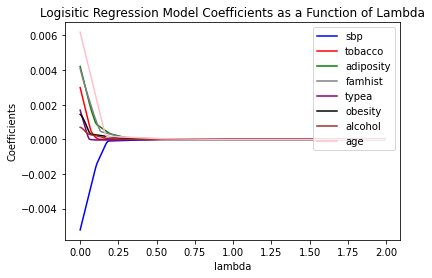




The optimal lambda found was:  0.05
From the lasso plot, it appears that the most important features are
sbp, age, adiposity, and famhist



--------------COMPARING PERFORMANCE OF MODELS ON DATASET--------------


From the results received from the forward stepwise algorithm, it appears
that the most important features are:  ['adiposity', 'age', 'tobacco', 'ldl']
0.0






,Unregularized,Forward Stepwise,L2 Regularization,L1 Regularization
0,85.106383,89.361702,85.106383,87.234043


In [ ]:
#here we see the results of all the different experiments we ran on the SAheart dataset
#we make the lasso plot, and we call on main to see how the 4 models did


xtrain, ytrain, xtest, ytest, xval, yval = prepare_data("SAheart.csv", "chd", ["famhist"])

print("--------------RESULTS OF TRAINING MODEL USING L1 REGULARIZATION--------------")
print("\n\n")
coef_plot()

print("\n\n")

print("--------------COMPARING PERFORMANCE OF MODELS ON DATASET--------------")

print("\n")
main()




In [ ]:
#here we try out our algorithm on a different dataset, clinical records showing whether a patient
#died of heart failure or not and certain relevant features
xtrain, ytrain, xtest, ytest, xval, yval = prepare_data("heart_failure_clinical_records_dataset.csv", "DEATH_EVENT", 
                                                        ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"])

print(len(ytest))

main()

30
From the results received from the forward stepwise algorithm, it appears
that the most important features are:  ['time', 'ejection_fraction', 'creatinine_phosphokinase', 'platelets']






,Unregularized,Forward Stepwise,L2 Regularization,L1 Regularization
0,93.333333,86.666667,93.333333,90.0


In [ ]:
#here we plot the scatterplot matrix for the heart failure dataset

scatterplot("heart_failure_clinical_records_dataset.csv", "DEATH_EVENT")

From the results received from the forward stepwise algorithm, it appears
that the most important features are:  ['g3', 'p4', 'p2', 'stab']






,Unregularized,Forward Stepwise,L2 Regularization,L1 Regularization
0,93.4,95.6,0.934,0.934


In [ ]:
#Here is our implementation of multinomial classification on the dry beans dataset
#there wasn't any good way of editing functions like step, hyp_func, and fit_model
#so that they worked for binomial and multinomial classification so we just redefined
#them for multinomial classification here

xtrain, ytrain, xtest, ytest, xval, yval = prepare_data("Dry_Beans_Dataset.csv", "Class", [])

#The main difference between binomial and multinomial classification is that 
#now each class gets its own weight vector and the hyp_function is a little bit different
#but other than that it's pretty similar

#step function updates a certain weight vector 
#takes in index, which tells it which weight vector to update
#xi, the features of a datapoint, yi, the label of that datapoint
#alpha, the step size, and W the ist of weight vectors

def step(index, xi, yi, alpha, W):

  #so if we are calculating update function for the weight vector corresponding
  #to the jth class, ti is 0 when i != j and 1 when i == j

  ti = 0
  #since our labels are binary strings from 0 to 6
  #if we convert them to decimal we can check which class we're in since the index
  #corresponds to the class too

  if int(yi, 2) == index:
    ti = 1

  #once we find out ti, we updat ethe function just as before
  return W[index] + alpha*(ti - hyp_func(W[index], W, xi))*xi

#hyp_func is the other thing that changes
#it takes in the weight vector, beta,
#W, the weight matrix, and x, then feature values of the datapoint

def hyp_func(beta, W, x):

  #transpose beta
  beta_tran = np.transpose(beta)

  denom = 0

  #the denominator of the hyp_func is the sum of e raised to the power
  #of the dot product of each of the weight vectors with x

  #iterate through each of the weight vectors
  for weights in W:
    
    #add the exponentiated dot product to denom
    weight_tran = np.transpose(weights)

    denom += math.exp(np.matmul(weight_tran, x))
  
  #divide the exponentiated dot product of beta and x by denom
  return math.exp(np.matmul(beta_tran, x))/denom


#fits the model by running through each of the datapoints
#and updating each weight vector using the step function

#takes in x, the feature values, y, the labels and alpha,
#the step size
def fit_model(x, y, alpha):

  #make an array for all of the weights, W
  W = [[0] * np.shape(x)[1] for _ in range(7)]


  #for each datapoint
  for index in range(np.shape(x)[0]):

    #update each weight vector in W
    for idx in range(len(W)):

      W[idx] = step(idx, x[index], y[index], alpha, W)
  
  return W

#predict function takes in the feature values, x, the labels, y, 
#and W, the weight matrix produced by the model

#returns the percent of classifications made by the model that were correct

def predict(x, y, W):

  numCorrect = 0

  #for each datapoint
  for index in range(len(x)):

    #calculate the probability of the label being each of the classes
    #given x
    predictions = [hyp_func(beta, W, x[index]) for beta in W]

    #get the index of the best prediction
    classification = predictions.index(max(predictions))


    
    #if the index is equal to the decimal representation of the 
    #label for y, we correctly predicted the label
    if classification == int(y[index], 2):
      numCorrect += 1
  
  return 100*numCorrect/len(x)


#convert the training set to numpy arrays
xtrain_mat = xtrain.to_numpy()
ytrain_mat = ytrain.to_numpy()

#train the model on the set
W = fit_model(xtrain_mat, ytrain_mat, 0.0001)

#convert testing set to numpy array
xtest_mat = xtest.to_numpy()
ytest_mat = ytest.to_numpy()
#find out what percent of classifications our model got right
score = predict(xtest_mat, ytest_mat, W)



print("For the dry beans dataset, our model was able to achieve an accuracy of", score, "% on the testing set.")

For the dry beans dataset, our model was able to achieve an accuracy of 69.30983847283407 % on the testing set.



# Summary

**Unregularized**

On the South African heart disease dataset, our unregularlized model consistently had a percent correct in the range of 65% - 76%.

On the dataset that we chose, a heart failure clinical record dataset (https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records), our unregularized model had a percent correct of around 80%.

**Forward Stepwise**

For our forward stepwise model, we aimed to select the features that were the most important to the model's performance. We did this by building all one feature models and selecting k models with the best score. After building all of the one feature models, we built all two feature models based off the best k models obtained in the previous step. After the last iteration, we select the best performing model, which dedcides on which k features are the best to include in our model. In our case, we decide on making k to equal 4 for easier comparison to the textbook's anaylsis done on the SA heart disease dataset. 

On the South African heart disease dataset, our model decided that the best features were: 'age', 'famhist', 'tobacco', and'sbp'. The percent correct fell into a similar range as our unregularized model, but noticably never fell below 60% across different train-test shuffles. 

On the dataset we chose, our model decided that the best features were: 'time', 'high_blood_pressure', 'serum_sodium', 'anaemia'. The forward stepwise performed worse than our other models, having a percent correct of around 70%.

**L1 Regularized**

For our L1 regularized model, we used the update method the paper (https://aclanthology.org/P09-1054.pdf) referred to as "SDG L1 (Clipping)". This method involves first updating the weight without the L1 penalty term. Then, we add the derivative (+- lambda) of the L1 penalty. However, if there is a sign change, the weight is "clipped" to 0.

For both the South African heart disease dataset and the dataset that we chose, the percent correct tended to fall within the same percent range as our unregularized model: 65%-76% for the SA heart dataset, and ~80% for the heart failure dataset. 

Using the validation dataset and the Lasso plot we produced, we got optimal lambdas in a range from 0 to 0.3, and the most important features were sbp, age, adiposity, and famhist. These results are fairly similar to the results we obtained from our forward stepwise model, where features age, fhamist, tobacco and sbp were selected. The two models' selected features were only off by one, differing by tobacco and adiposity.

The textbook's analysis done on the South African heart disease dataset determined that the optimal features to include in the model were tobacco, ldl, famhist, and age. Comparing these results to the optimal features selected from our L1 regularized model and our step forward model, our L1 regularized model's selected features were off by two (sbp and adiposity vs tobacco and ldl) and our step forward model's selecte features were off by 1 (ldl and sbp).

**L2 Regularized**

For the L2 regularized model, we added the gradient of the L2 penalty to the update function. We found that the optimal lambdas for the L2 regularized models ranged from 0 to 0.16. 

For both the South African heart disease dataset and the dataset that we chose, the percent correct tended to fall within the same percent range as our unregularized and L1 regularized model: 65%-76% for the SA heart dataset, and ~80% for the heart failure dataset. 

**Unregularized Multinomal Regression**

We extended our unregularized model to mutlinomial regression and tested it on a dry bean dataset from the UCI repository where features such as shape and perimeter are used to predict the type of dry bean.
The primary difference between binomial and multinomial regression is that each class (the type of dry bean in this case) now gets their own weight vector, and both the update function and hypothesis functions change. The denominator of the hypothesis function in the multinominal case becomes the sum of e raised to the power of the dot product of each of the weight vectors with x. The new update formula updates weight vectors based on the index that is provided to the function. The new update formula and the hypothesis function used for our implmentation of multinominal regression was taken from section 4.3.4 of a ML text by Bishop (http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)

There are seven types of dry beans that the model is aiming to predict. Therefore, we encoded our labels into binary strings, where each dry bean would be represented in combinations of three bits. We later converted the binary strings to decimal when necessary in the update function to check which class a label belonged to. 

Our unregularized, multinominal model produced a percent correct of around 70% percent across different train-test shuffles. 